In [44]:
from SketchKeras.sketch_model import SketchKeras
import SketchKeras.sketchkeras as SK
import torch
from torchvision import transforms as T
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer, util
from PIL import Image
from skimage.metrics import structural_similarity as ssim

model = SentenceTransformer('clip-ViT-B-32')
PATCH_SIZE = 16

In [45]:
SKETCH_PATH = 'SketchKeras/model.pth'
sketchKeras = SketchKeras()
sketchKeras.load_state_dict(torch.load(SKETCH_PATH))
sketchKeras.to(model.device)

SketchKeras(
  (downblock_1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(32, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (downblock_2): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (2): BatchNorm2d(64, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(64, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (downblock_3): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (2): BatchNorm2d(128, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), st

In [46]:
def sketch(image,theshold=253):
    img_shape = image.shape

    image = SK.load_image(image)

    image = sketchKeras(image.to(model.device))
    image = image.cpu().detach().numpy()
    
    sketch_image = SK.postprocess(image[0])
    sketch_image = T.ToPILImage()(sketch_image)
    sketch_image = T.Resize(size=(img_shape[0],img_shape[1]))(sketch_image)
    sketch_image= np.array(sketch_image)
    sketch_image = np.where(sketch_image > theshold, 255, 0).astype(np.uint8)
    return sketch_image


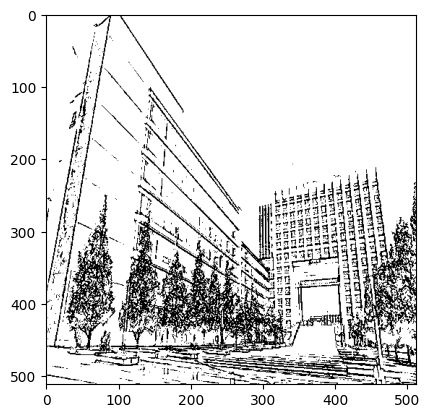

In [47]:
image = np.array(Image.open("sit_toyosu.png").convert('RGB').resize((512,512)))

sketch = sketch(image)

plt.imshow(sketch,cmap='gray')

In [48]:
def extract_patches(image, n, m):  
    patches = []
    image = np.array(image)
    height, width = image.shape[:2]
    images_height =0
    images_width = 0

    for y in range(0, height - n + 1, m):
        images_height += 1
        for x in range(0, width - n + 1, m):  
            images_width += 1          
            patch = image[y:y+n, x:x+n]
            patches.append(patch)
    images_width = images_width//images_height

    return np.array([patch for patch in patches]), images_width, images_height

In [49]:
ascii_imgs, _, _ = extract_patches(Image.open('output.png'), PATCH_SIZE, PATCH_SIZE)
normal_imgs, _, _ = extract_patches(sketch, PATCH_SIZE, PATCH_SIZE)

In [50]:
def score_image(image1, image2):
    encoded_image = model.encode([Image.fromarray(image1),Image.fromarray(image2)], batch_size=128, convert_to_tensor=True)
    processed_images = util.paraphrase_mining_embeddings(encoded_image)
    return processed_images

In [51]:
scores = []

for ascii_img, normal_img in zip(ascii_imgs, normal_imgs):
    scores.append(score_image(ascii_img, normal_img))

In [52]:
scores_ssim = []
for ascii_img, normal_img in zip(ascii_imgs, normal_imgs):
    score, diff = ssim(ascii_img, normal_img, full=True)
    if score < 0:
        score = 0
    scores_ssim.append(score * 100)

In [53]:
for i, score in enumerate(scores_ssim):
    print(f'Image {i} : {score:.2f}%')
    # plt.subplot(1, 2, 1)
    # plt.imshow(ascii_imgs[i], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(normal_imgs[i], cmap='gray')
    # plt.show()

Image 0 : 100.00%
Image 1 : 100.00%
Image 2 : 100.00%
Image 3 : 99.21%
Image 4 : 50.31%
Image 5 : 0.00%
Image 6 : 39.86%
Image 7 : 99.04%
Image 8 : 100.00%
Image 9 : 100.00%
Image 10 : 100.00%
Image 11 : 100.00%
Image 12 : 100.00%
Image 13 : 100.00%
Image 14 : 100.00%
Image 15 : 100.00%
Image 16 : 100.00%
Image 17 : 100.00%
Image 18 : 100.00%
Image 19 : 100.00%
Image 20 : 100.00%
Image 21 : 100.00%
Image 22 : 100.00%
Image 23 : 100.00%
Image 24 : 100.00%
Image 25 : 100.00%
Image 26 : 100.00%
Image 27 : 100.00%
Image 28 : 100.00%
Image 29 : 100.00%
Image 30 : 100.00%
Image 31 : 100.00%
Image 32 : 100.00%
Image 33 : 100.00%
Image 34 : 100.00%
Image 35 : 99.99%
Image 36 : 56.33%
Image 37 : 28.15%
Image 38 : 99.06%
Image 39 : 37.51%
Image 40 : 100.00%
Image 41 : 100.00%
Image 42 : 100.00%
Image 43 : 100.00%
Image 44 : 100.00%
Image 45 : 100.00%
Image 46 : 100.00%
Image 47 : 100.00%
Image 48 : 100.00%
Image 49 : 100.00%
Image 50 : 100.00%
Image 51 : 100.00%
Image 52 : 100.00%
Image 53 : 100

In [54]:
for i, score in enumerate(scores):
    print(f'Image {i} : {(score[0][0]*100):.2f}%')
    # plt.subplot(1, 2, 1)
    # plt.imshow(ascii_imgs[i], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(normal_imgs[i], cmap='gray')
    # plt.show()

Image 0 : 100.00%
Image 1 : 100.00%
Image 2 : 100.00%
Image 3 : 98.15%
Image 4 : 89.32%
Image 5 : 92.79%
Image 6 : 90.78%
Image 7 : 95.99%
Image 8 : 100.00%
Image 9 : 100.00%
Image 10 : 100.00%
Image 11 : 100.00%
Image 12 : 100.00%
Image 13 : 100.00%
Image 14 : 100.00%
Image 15 : 100.00%
Image 16 : 100.00%
Image 17 : 100.00%
Image 18 : 100.00%
Image 19 : 100.00%
Image 20 : 100.00%
Image 21 : 100.00%
Image 22 : 100.00%
Image 23 : 100.00%
Image 24 : 100.00%
Image 25 : 100.00%
Image 26 : 100.00%
Image 27 : 100.00%
Image 28 : 100.00%
Image 29 : 100.00%
Image 30 : 100.00%
Image 31 : 100.00%
Image 32 : 100.00%
Image 33 : 100.00%
Image 34 : 100.00%
Image 35 : 99.04%
Image 36 : 93.33%
Image 37 : 86.99%
Image 38 : 96.22%
Image 39 : 92.61%
Image 40 : 100.00%
Image 41 : 100.00%
Image 42 : 100.00%
Image 43 : 100.00%
Image 44 : 100.00%
Image 45 : 100.00%
Image 46 : 100.00%
Image 47 : 100.00%
Image 48 : 100.00%
Image 49 : 100.00%
Image 50 : 100.00%
Image 51 : 100.00%
Image 52 : 100.00%
Image 53 : 10

Image similarity : 48.19%


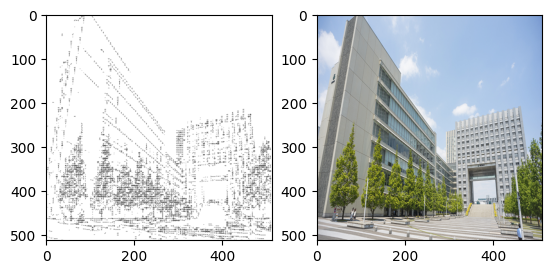

In [55]:
image_mean = np.array(scores_ssim).mean()
print(f'Image similarity : {image_mean:.2f}%')
plt.subplot(1, 2, 1)
plt.imshow(Image.open("output.png"), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.show()

Image similarity : 64.96%


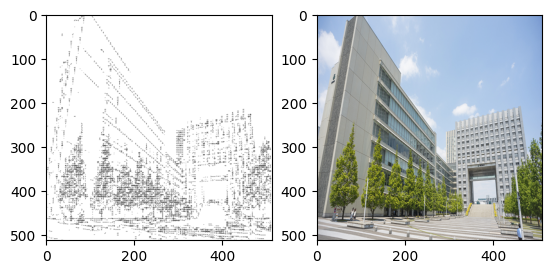

In [56]:
image_mean = np.array(scores).mean()
print(f'Image similarity : {(image_mean*100):.2f}%')
plt.subplot(1, 2, 1)
plt.imshow(Image.open("output.png"), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.show()